# The research paper can be downloaded from  https://doi.org/10.1155/2022/8379202. The dataset used here can be accessed from here: https://drive.google.com/drive/folders/1l_Leo2HxSPvfJ_QqyuAISa7gdkTnIEsc?usp=sharing

##Mounting drive to colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Importing necessary packages

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
import cv2   #for reading images
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Preprocessing the images

In [ ]:
image=cv2.imread("/content/drive/MyDrive/deep_learning_project/face_expression_dataset/train/angry/Training_2944904.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
image.shape

(48, 48)

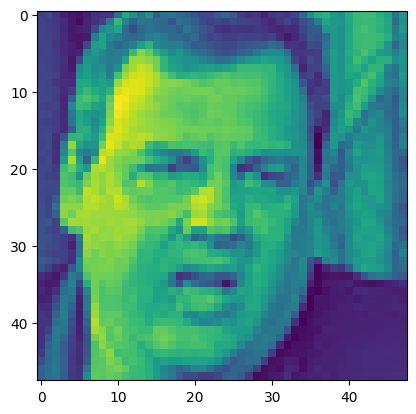

In [ ]:
plt.imshow(image)

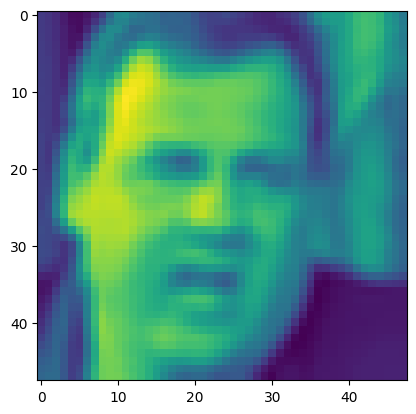

In [ ]:
# Apply the box average filter
box_filtered_image = cv2.boxFilter(image, -1, (3, 3))
plt.imshow(box_filtered_image)

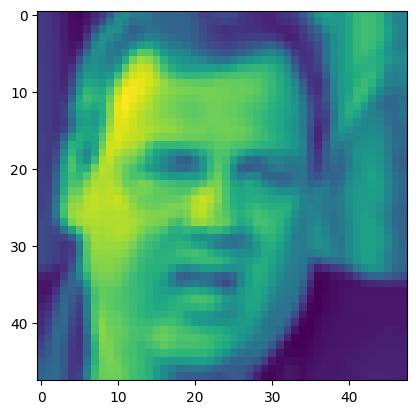

In [ ]:
# Apply the Gaussian filter
gaussian_filtered_image = cv2.GaussianBlur(image, (3, 3), 0)
plt.imshow(gaussian_filtered_image)

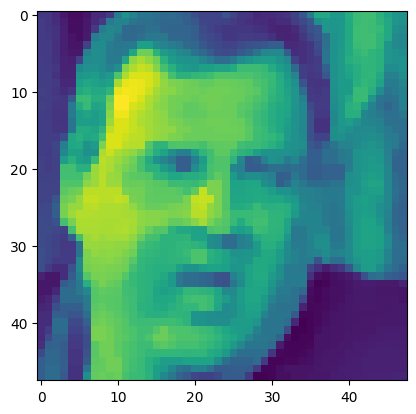

In [ ]:
# Apply the median filter
median_filtered_image = cv2.medianBlur(image, 3)
plt.imshow(median_filtered_image)

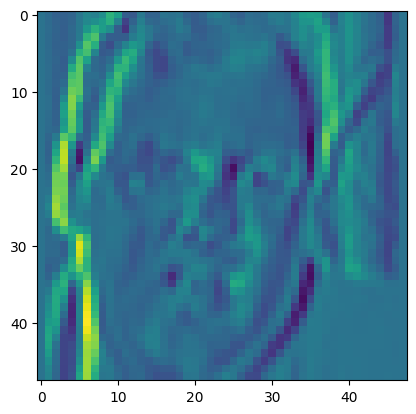

In [ ]:
# Apply the Prewitt operator
prewitt = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
plt.imshow(prewitt)

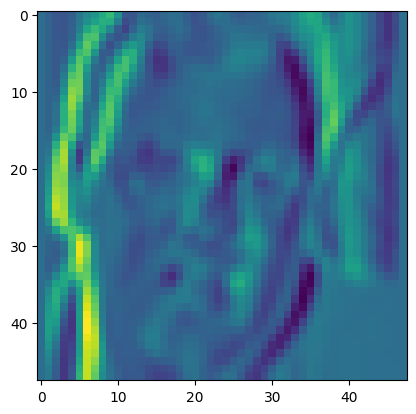

In [ ]:
# Apply the Sobel operator
sobel = cv2.Sobel(gaussian_filtered_image, cv2.CV_64F, 1, 0, ksize=3)
plt.imshow(sobel)

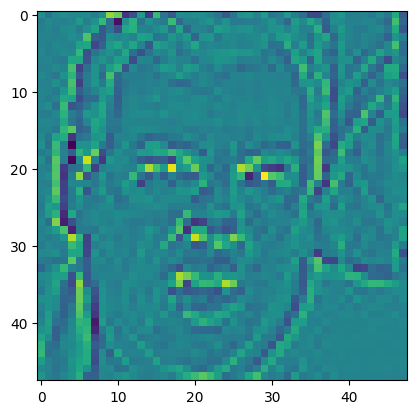

In [ ]:
# Apply the Laplacian operator
laplacian = cv2.Laplacian(image, cv2.CV_64F)
plt.imshow(laplacian)

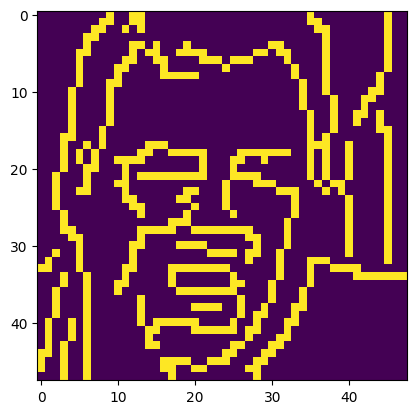

In [ ]:
# Apply the Canny edge detector
edges = cv2.Canny(gaussian_filtered_image, 50, 150)
plt.imshow(edges)

In [ ]:
print(edges)

[[  0   0   0 ... 255   0   0]
 [  0   0   0 ... 255   0   0]
 [  0   0   0 ... 255   0   0]
 ...
 [255   0   0 ...   0   0   0]
 [255   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


(48, 48)


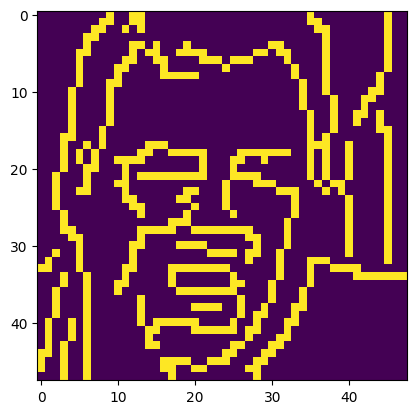

In [ ]:
binary = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY)[1]
plt.imshow(binary)
print(binary.shape)

##Preprocess function implemented from research paper

In [ ]:
def preprocess(image):
     gaussian_filtered_image = cv2.GaussianBlur(image, (3, 3), 0)
     if gaussian_filtered_image.dtype != "uint8":
      gaussian_filtered_image = gaussian_filtered_image.astype("uint8")
     edges = cv2.Canny(gaussian_filtered_image, 50, 150)
     binary = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY)[1]
     binary_with_channel = np.expand_dims(binary, axis=-1)  # Add channel dimension
     return binary_with_channel

In [ ]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(preprocessing_function=preprocess)
validation_data_gen = ImageDataGenerator(preprocessing_function=preprocess)

In [ ]:
# Preprocess all train images
train_generator = train_data_gen.flow_from_directory(
        '/content/drive/MyDrive/deep_learning_project/face_expression_dataset/train',
        target_size=(48, 48),
        batch_size=200,
        color_mode="grayscale",
        class_mode='categorical')

Found 8526 images belonging to 7 classes.


In [ ]:
# Preprocess all test images
validation_generator = validation_data_gen.flow_from_directory(
        '/content/drive/MyDrive/deep_learning_project/face_expression_dataset/test',
        target_size=(48, 48),
        batch_size=200,
        color_mode="grayscale",
        class_mode='categorical')

Found 1178 images belonging to 7 classes.


##Creating the CNN model using Keras

In [ ]:
class OurModel(Model):
  def __init__(self):
    super(OurModel,self).__init__()

    self.input1 = Sequential([
        Conv2D(64, kernel_size=(3,3),strides=(1,1)),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(pool_size=(2,2), strides=1,padding='valid')
    ])
    self.conv1 = Sequential([
        Conv2D(64, kernel_size=(3,3),strides=(1,1)),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(pool_size=(2,2), strides=1,padding='valid')
    ])
    self.out = Sequential([
        Flatten(),
        Dense(100, activation="relu"),
        Dense(100, activation="relu"),
        Dense(7, activation="softmax")
    ])

  def call(self, x):
    x = self.input1(x)
    x = self.conv1(x)
    x = self.out(x)
    return x

In [ ]:
model = OurModel()
model.build(input_shape=(None,48,48,1))

In [ ]:
model.summary()

Model: "our_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 45, 45, 64)        896       
                                                                 
 sequential_1 (Sequential)   (None, 42, 42, 64)        37184     
                                                                 
 sequential_2 (Sequential)   (None, 7)                 11300507  
                                                                 
Total params: 11338587 (43.25 MB)
Trainable params: 11338331 (43.25 MB)
Non-trainable params: 256 (1.00 KB)
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
%%time
our_model = model.fit_generator(
        train_generator,
        steps_per_epoch=8526 // 200,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=1178 // 200)

<timed exec>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
42/42 [==============================] - 2256s 54s/step - loss: 17.3826 - accuracy: 0.1811 - val_loss: 9.2701 - val_accuracy: 0.2040
Epoch 2/20
42/42 [==============================] - 257s 6s/step - loss: 2.6254 - accuracy: 0.2525 - val_loss: 4.8132 - val_accuracy: 0.2110
Epoch 3/20
42/42 [==============================] - 259s 6s/step - loss: 3.0067 - accuracy: 0.2545 - val_loss: 7.4365 - val_accuracy: 0.1640
Epoch 4/20
42/42 [==============================] - 250s 6s/step - loss: 2.8697 - accuracy: 0.2772 - val_loss: 2.3644 - val_accuracy: 0.2430
Epoch 5/20
42/42 [==============================] - 266s 6s/step - loss: 1.7839 - accuracy: 0.3359 - val_loss: 2.0227 - val_accuracy: 0.2970
Epoch 6/20
42/42 [==============================] - 256s 6s/step - loss: 1.7512 - accuracy: 0.3608 - val_loss: 1.8595 - val_accuracy: 0.3070
Epoch 7/20
42/42 [==============================] - 259s 6s/step - loss: 1.7158 - accuracy: 0.3762 - val_loss: 2.0989 - val_accuracy: 0.2790
Epoch 8/20

In [ ]:
# save trained model weight in .h5 file
model.save_weights('/content/drive/MyDrive/research_paper/research_paper_model.h5')

In [ ]:
emotion_model = OurModel()
emotion_model.build(input_shape=(None,48,48,1))
emotion_model.load_weights('/content/drive/MyDrive/research_paper/research_paper_model.h5')
print("Loaded model from disk")

Loaded model from disk


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

# Initialize image data generator with rescaling
test_data_gen = ImageDataGenerator(preprocessing_function=preprocess)

# Preprocess all test images
test_generator = test_data_gen.flow_from_directory(
        '/content/drive/MyDrive/deep_learning_project/face_expression_dataset/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 1178 images belonging to 7 classes.


In [ ]:
predictions = emotion_model.predict_generator(test_generator)

<ipython-input-28-5a7f1182a3ff>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = emotion_model.predict_generator(test_generator)


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy}')

19/19 [==============================] - 10s 526ms/step - loss: 2.5105 - accuracy: 0.2852
Test accuracy: 0.2852292060852051


In [ ]:
print(classification_report(test_generator.classes, predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.12      0.02      0.03       185
           1       0.06      0.02      0.03       111
           2       0.18      0.21      0.20       225
           3       0.12      0.08      0.09       184
           4       0.16      0.07      0.10       169
           5       0.14      0.54      0.22       158
           6       0.12      0.03      0.04       146

    accuracy                           0.14      1178
   macro avg       0.13      0.14      0.10      1178
weighted avg       0.13      0.14      0.11      1178



## Using Depth Wise Convolution in the model to reduce the number of traninable paprameters

In [ ]:
class OurModel(Model):
  def __init__(self):
    super(OurModel,self).__init__()

    self.input1 = Sequential([
        DepthwiseConv2D(kernel_size=(3,3),strides=(1,1)),
        Conv2D(64, kernel_size=(1,1),strides=(1,1)),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(pool_size=(2,2), strides=1,padding='valid')
    ])
    self.conv1 = Sequential([
        DepthwiseConv2D(kernel_size=(3,3),strides=(1,1)),
        Conv2D(64, kernel_size=(1,1),strides=(1,1)),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(pool_size=(2,2), strides=1,padding='valid')
    ])
    self.conv2 = Sequential([
        DepthwiseConv2D(kernel_size=(3,3),strides=(1,1)),
        Conv2D(64, kernel_size=(1,1),strides=(1,1)),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(pool_size=(2,2), strides=1,padding='valid')
    ])
    self.out = Sequential([
        Flatten(),
        Dense(100, activation="relu"),
        Dense(100, activation="relu"),
        Dense(7, activation="softmax")
    ])

  def call(self, x):
    x = self.input1(x)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.out(x)
    return x

In [ ]:
model = OurModel()
model.build(input_shape=(None,48,48,1))

In [ ]:
model.summary()

Model: "our_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 45, 45, 64)        394       
                                                                 
 sequential_5 (Sequential)   (None, 42, 42, 64)        5056      
                                                                 
 sequential_6 (Sequential)   (None, 39, 39, 64)        5056      
                                                                 
 sequential_7 (Sequential)   (None, 7)                 9745307   
                                                                 
Total params: 9755813 (37.22 MB)
Trainable params: 9755429 (37.21 MB)
Non-trainable params: 384 (1.50 KB)
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001,decay=1e-4,clipvalue=0.2),
              metrics=['accuracy'])

In [ ]:
%%time
our_model = model.fit_generator(
        train_generator,
        steps_per_epoch=8526 // 200,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=1178 // 200)

<timed exec>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
42/42 [==============================] - 33s 763ms/step - loss: 8.0676 - accuracy: 0.1930 - val_loss: 1.9207 - val_accuracy: 0.1830
Epoch 2/20
42/42 [==============================] - 31s 749ms/step - loss: 2.0279 - accuracy: 0.2636 - val_loss: 1.9153 - val_accuracy: 0.2390
Epoch 3/20
42/42 [==============================] - 30s 705ms/step - loss: 1.8756 - accuracy: 0.2969 - val_loss: 1.9447 - val_accuracy: 0.2600
Epoch 4/20
42/42 [==============================] - 31s 726ms/step - loss: 1.8605 - accuracy: 0.3267 - val_loss: 1.8480 - val_accuracy: 0.2820
Epoch 5/20
42/42 [==============================] - 30s 699ms/step - loss: 1.7918 - accuracy: 0.3417 - val_loss: 1.9253 - val_accuracy: 0.2110
Epoch 6/20
42/42 [==============================] - 31s 744ms/step - loss: 1.7787 - accuracy: 0.3410 - val_loss: 1.9067 - val_accuracy: 0.2300
Epoch 7/20
42/42 [==============================] - 31s 731ms/step - loss: 1.5831 - accuracy: 0.4015 - val_loss: 1.8258 - val_accuracy: 0.2600

In [ ]:
# save trained model weight in .h5 file
model.save_weights('/content/drive/MyDrive/research_paper/research_paper_model_new.h5')

In [ ]:
emotion_model = OurModel()
emotion_model.build(input_shape=(None,48,48,1))
emotion_model.load_weights('/content/drive/MyDrive/research_paper/research_paper_model_new.h5')
print("Loaded model from disk")

Loaded model from disk


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

# Initialize image data generator with rescaling
test_data_gen = ImageDataGenerator(preprocessing_function=preprocess)

# Preprocess all test images
test_generator = test_data_gen.flow_from_directory(
        '/content/drive/MyDrive/deep_learning_project/face_expression_dataset/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 1178 images belonging to 7 classes.


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy}')

19/19 [==============================] - 5s 210ms/step - loss: 2.8232 - accuracy: 0.3430
Test accuracy: 0.342954158782959
